In [47]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools
from bold_dementia.connectivity import Atlas, group_by_networks, plot_matrix, reshape_pvalues, block_block
from bold_dementia.utils.iterables import unique

ATLAS = "gillig-regions"
SOFT = False
#ALPHA = config["alpha"]
ALPHA = 0.05

In [48]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
coords = atlas.get_coords()

In [49]:
expname = f"atlas-{ATLAS}_default_ols-cenanom-block"
matrices_path = Path(
    f"{config['output_dir']}/statresults/{expname}"
)
print(f"Loading matrices from {matrices_path}")
#AD_matrices = joblib.load(matrices_path / "AD.joblib")
#control_matrices = joblib.load(matrices_path / "control.joblib")
fdrmat = joblib.load(matrices_path / "pmat.joblib")
tstats = joblib.load(matrices_path / "statmap.joblib")

#n_AD = AD_matrices.shape[0]
#n_controls = control_matrices.shape[0]

atlas = Atlas.from_name(ATLAS, soft=SOFT)
atlas.labels_.pop(0)
n_regions = len(atlas.labels)

thresholded_t = tstats * np.where(fdrmat < ALPHA, 1, 0)
labels = tuple(sorted(unique(atlas.macro_labels)))

Loading matrices from /homes_unix/jlegrand/data/Memento/output/statresults/atlas-gillig-regions_default_ols-cenanom-block


In [50]:
resdf = pd.read_csv(matrices_path / "resdf.csv", index_col=0)
resdf["node_a"] = resdf["edges"].map(lambda edge: edge.split("_")[0])
resdf["node_b"] = resdf["edges"].map(lambda edge: edge.split("_")[1])

mask = np.where(resdf["pvalues_fdr"] < ALPHA, 1, 0) 
resdf["thresholded_beta"] = resdf["beta_AD"] * mask

resdf = resdf.drop("edges", axis=1)

In [51]:
resdf_pv = resdf.pivot(index="node_a" ,columns=["node_b"], values=["beta_AD", "pvalues_raw", "pvalues_fdr", "thresholded_beta"])

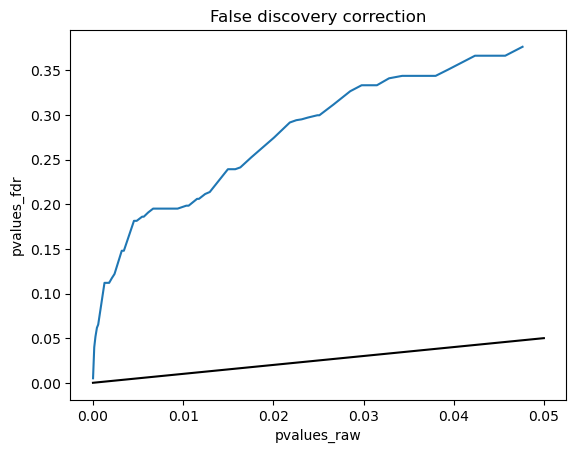

In [52]:
sns.lineplot(resdf[resdf.pvalues_raw < 0.05], x="pvalues_raw", y="pvalues_fdr")
x = np.linspace(0, 0.05, 100)
plt.plot(x, x, color="black")
plt.title(f"False discovery correction")
plt.show()

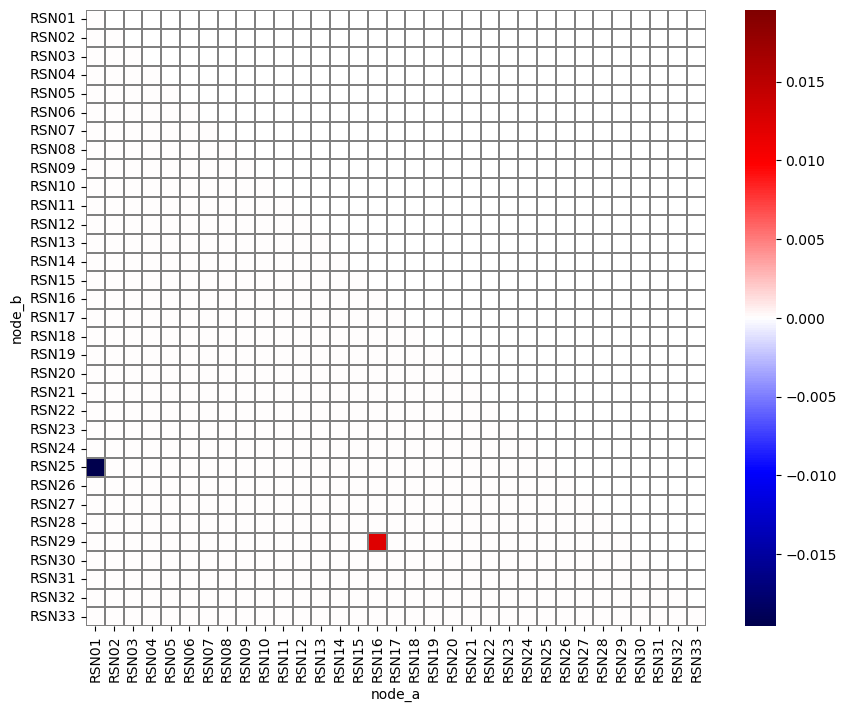

<Axes: xlabel='node_a', ylabel='node_b'>

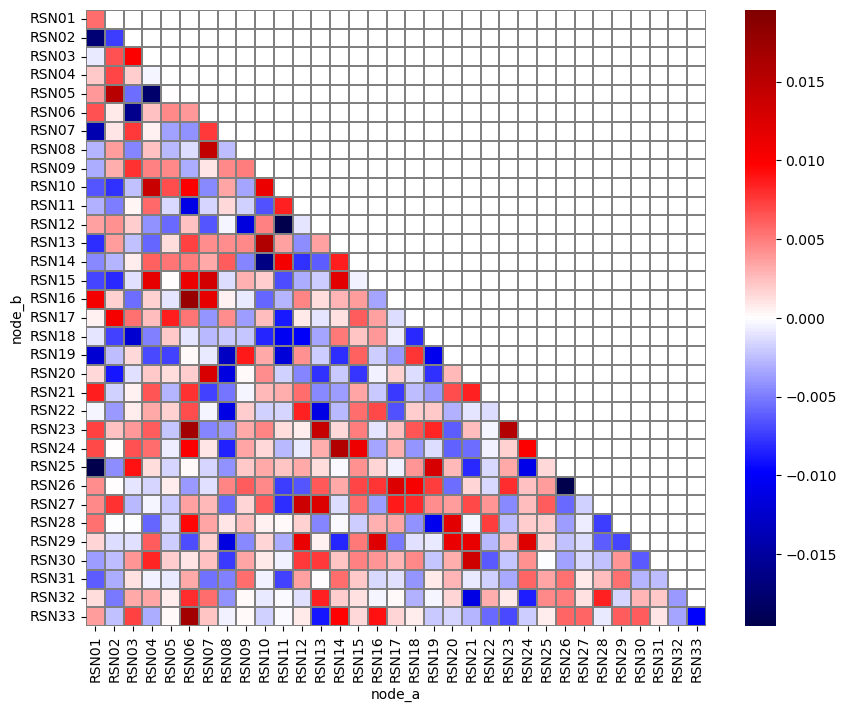

In [53]:
span = max(
    resdf["thresholded_beta"].min().__abs__(),
    resdf["thresholded_beta"].max().__abs__()
)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(
    resdf_pv.loc[:, "thresholded_beta"].T,
    vmin=-span, vmax=span, cmap="seismic", linewidths=0.1, linecolor="gray"
)

plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(
    resdf_pv.loc[:, "beta_AD"].T,
    vmin=-span, vmax=span, cmap="seismic", linewidths=0.1, linecolor="gray"
)

In [54]:
df = pd.DataFrame(atlas)

In [55]:
df[df.networks== "RSN25"].loc[:, "Cognitit"]

KeyError: 'Cognitit'

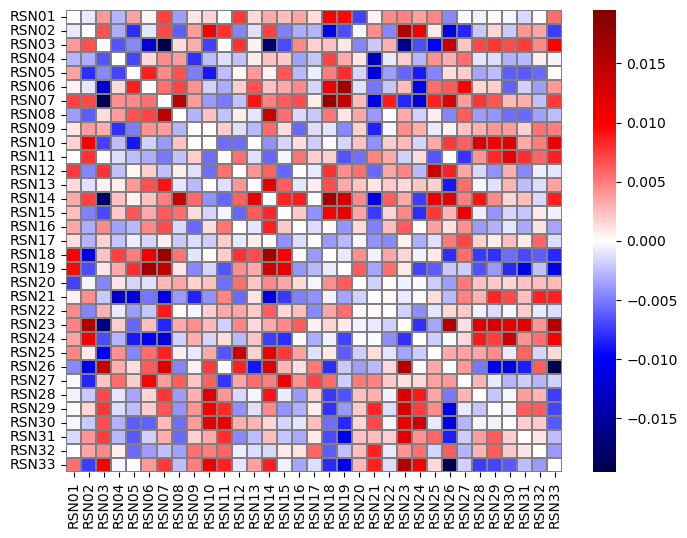

In [ ]:
from nilearn import plotting

span = np.max(np.abs(thresholded_t))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.heatmap(
    tstats,
    xticklabels=labels,
    yticklabels=labels,
    #title=f"{expname}\nthresholded t-values map",
    axes=ax,
    cmap="seismic",
    #grid=True,
    vmin=-span,
    vmax=span,
    linewidths=0.1,
    linecolor="gray",
    linestyle="--"
)
#plt.setp(ax.xaxis.get_majorticklabels(), ha="center", rotation_mode="anchor")
plt.show()

IndexError: index 429 is out of bounds for axis 0 with size 33

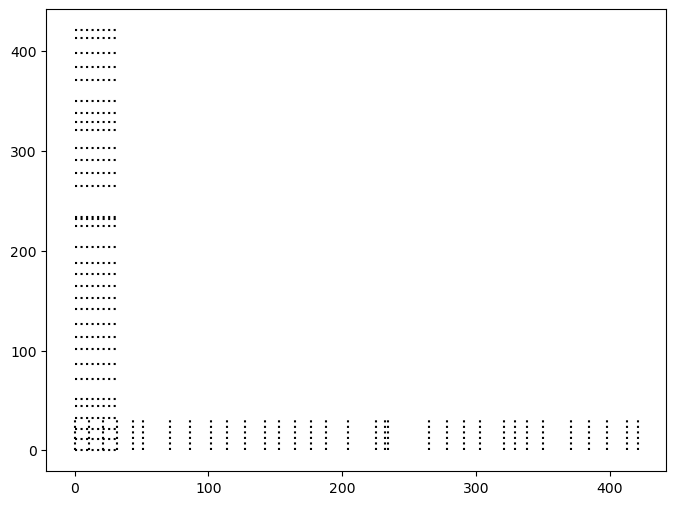

In [ ]:
from bold_dementia.connectivity import plot_ordered_matrix

plot_matrix(fdrmat, atlas, bounds=(0, 1), cmap="mako")
plt.title(f"{expname}\np-values map")
plt.show()

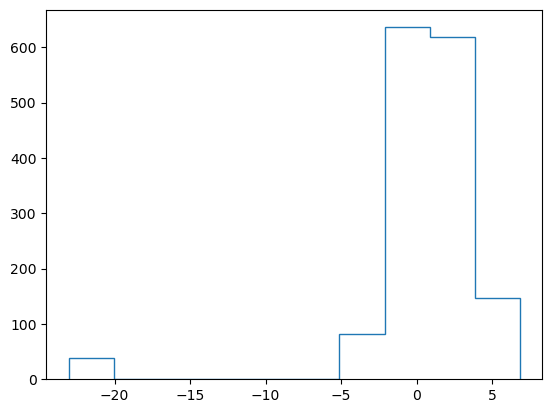

In [ ]:
from scipy.special import logit
eps = 1e-10
plt.hist(logit(fdrmat.flatten() + eps), histtype="step")
plt.show()

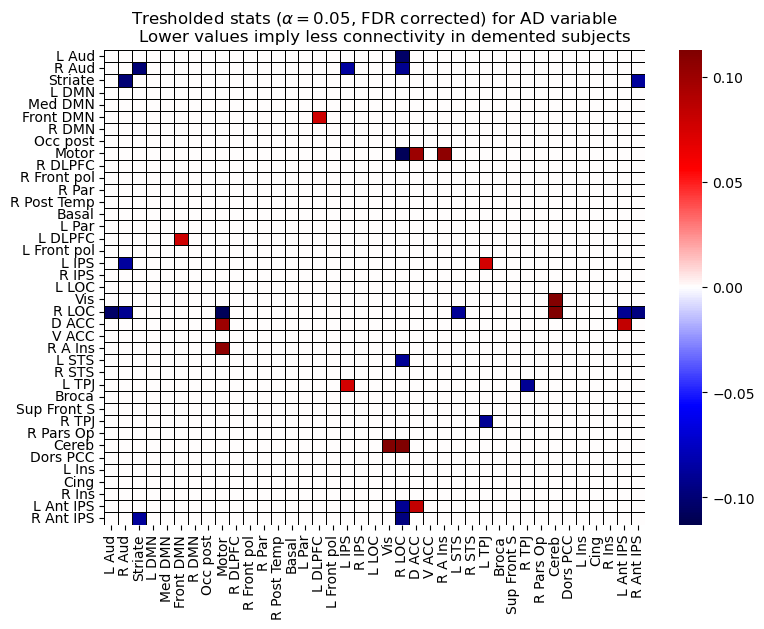

In [ ]:

thresholded_t = tstats * np.where(fdrmat < ALPHA, 1, 0)

plot_ordered_matrix(thresholded_t, atlas)

plt.title("Tresholded stats ($\\alpha = 0.05$, FDR corrected) for AD variable\n\
    Lower values imply less connectivity in demented subjects")
plt.show()

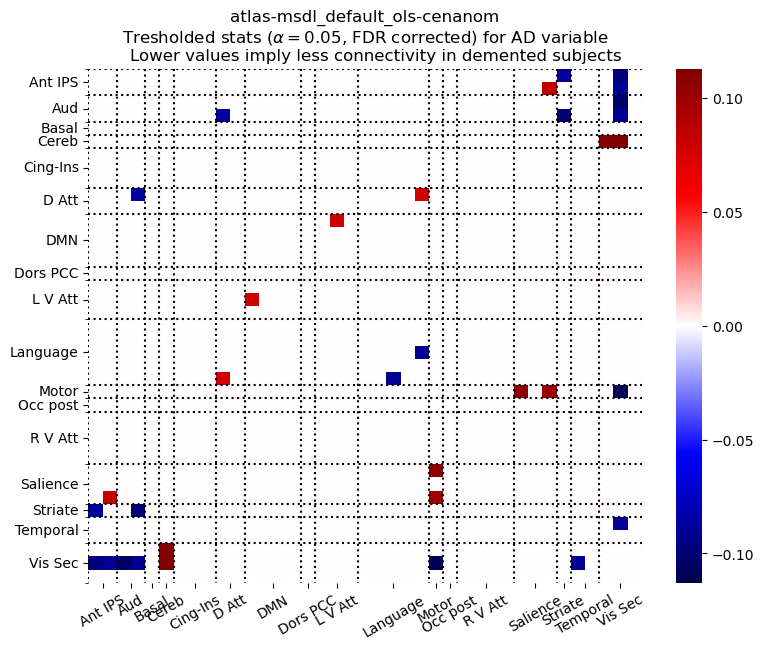

In [ ]:
plot_matrix(thresholded_t, atlas)
plt.title(f"{expname}\nTresholded stats ($\\alpha = 0.05$, FDR corrected) for AD variable\n\
    Lower values imply less connectivity in demented subjects")
plt.show()

In [ ]:
ticks, sort_index = group_by_networks(atlas.macro_labels)
block_mat = thresholded_t[np.ix_(sort_index, sort_index)]

In [ ]:
labels = [label for label in atlas.labels if label != "Background"]
dict(zip(labels, atlas.macro_labels))

{'L Aud': 'Aud',
 'R Aud': 'Aud',
 'Striate': 'Striate',
 'L DMN': 'DMN',
 'Med DMN': 'DMN',
 'Front DMN': 'DMN',
 'R DMN': 'DMN',
 'Occ post': 'Occ post',
 'Motor': 'Motor',
 'R DLPFC': 'R V Att',
 'R Front pol': 'R V Att',
 'R Par': 'R V Att',
 'R Post Temp': 'R V Att',
 'Basal': 'Basal',
 'L Par': 'L V Att',
 'L DLPFC': 'L V Att',
 'L Front pol': 'L V Att',
 'L IPS': 'D Att',
 'R IPS': 'D Att',
 'L LOC': 'Vis Sec',
 'Vis': 'Vis Sec',
 'R LOC': 'Vis Sec',
 'D ACC': 'Salience',
 'V ACC': 'Salience',
 'R A Ins': 'Salience',
 'L STS': 'Temporal',
 'R STS': 'Temporal',
 'L TPJ': 'Language',
 'Broca': 'Language',
 'Sup Front S': 'Language',
 'R TPJ': 'Language',
 'R Pars Op': 'Language',
 'Cereb': 'Cereb',
 'Dors PCC': 'Dors PCC',
 'L Ins': 'Cing-Ins',
 'Cing': 'Cing-Ins',
 'R Ins': 'Cing-Ins',
 'L Ant IPS': 'Ant IPS',
 'R Ant IPS': 'Ant IPS'}

In [ ]:
unique_m = sorted(tuple(unique(atlas.macro_labels)))
network_to_idx = pd.Series(dict(zip(
    unique_m,
    itertools.pairwise(ticks)
)))
network_to_idx

Ant IPS       (0, 2)
Aud           (2, 4)
Basal         (4, 5)
Cereb         (5, 6)
Cing-Ins      (6, 9)
D Att        (9, 11)
DMN         (11, 15)
Dors PCC    (15, 16)
L V Att     (16, 19)
Language    (19, 24)
Motor       (24, 25)
Occ post    (25, 26)
R V Att     (26, 30)
Salience    (30, 33)
Striate     (33, 34)
Temporal    (34, 36)
Vis Sec     (36, 39)
dtype: object

In [ ]:
gen = block_block(block_mat, network_to_idx)
comparisons = pd.DataFrame(gen, columns=["node_a", "node_b", "npos", "nneg", "activation"])

In [ ]:
comparisons_pv = comparisons.pivot(index="node_a", columns="node_b")

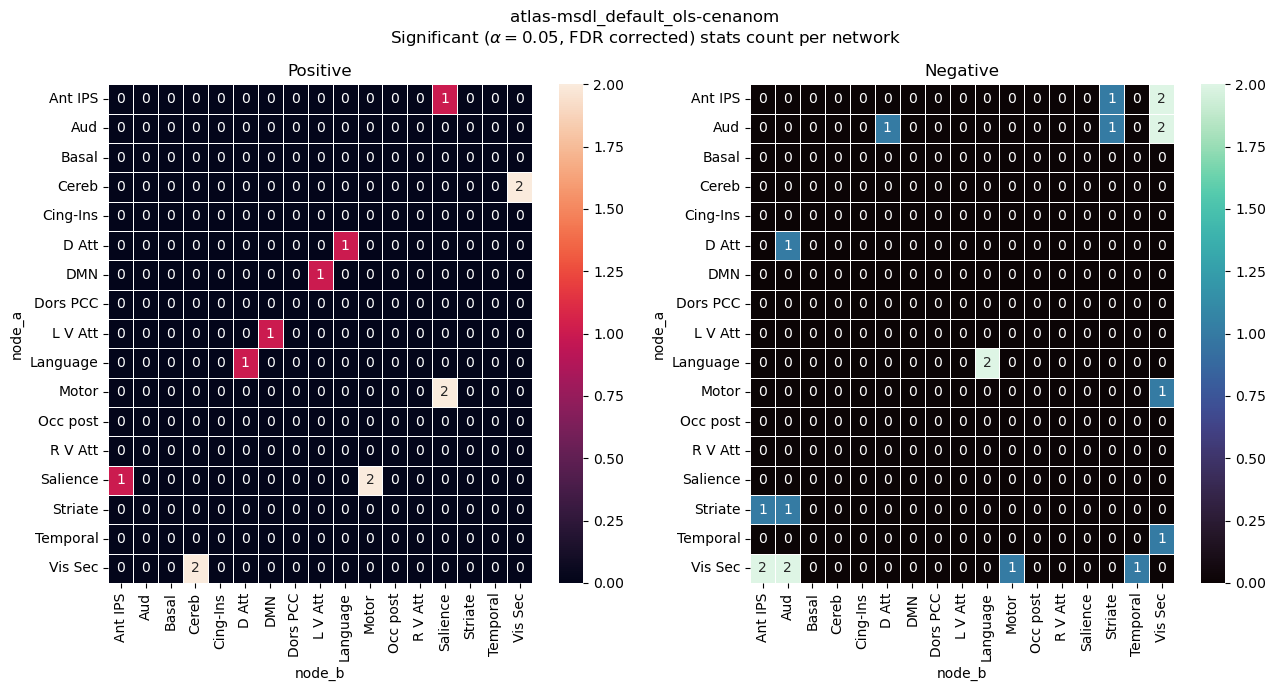

In [ ]:
max_count = max(comparisons[["npos", "nneg"]].max())

heat_kwargs = {
    "xticklabels":unique_m,
    "yticklabels":unique_m,
    "vmax": max_count,
    "annot": True,
    "linewidth": 0.5
}

fig, axes = plt.subplots(1, 2, figsize=(13, 7))
sns.heatmap(comparisons_pv.loc[:, "npos"], **heat_kwargs, cmap="rocket", ax=axes[0])
axes[0].set_title("Positive")

sns.heatmap(comparisons_pv.loc[:, "nneg"], **heat_kwargs, cmap="mako", ax=axes[1])
axes[1].set_title("Negative")
fig.suptitle(f"{expname}\nSignificant ($\\alpha = 0.05$, FDR corrected) stats count per network")
fig.tight_layout()
fig.show()

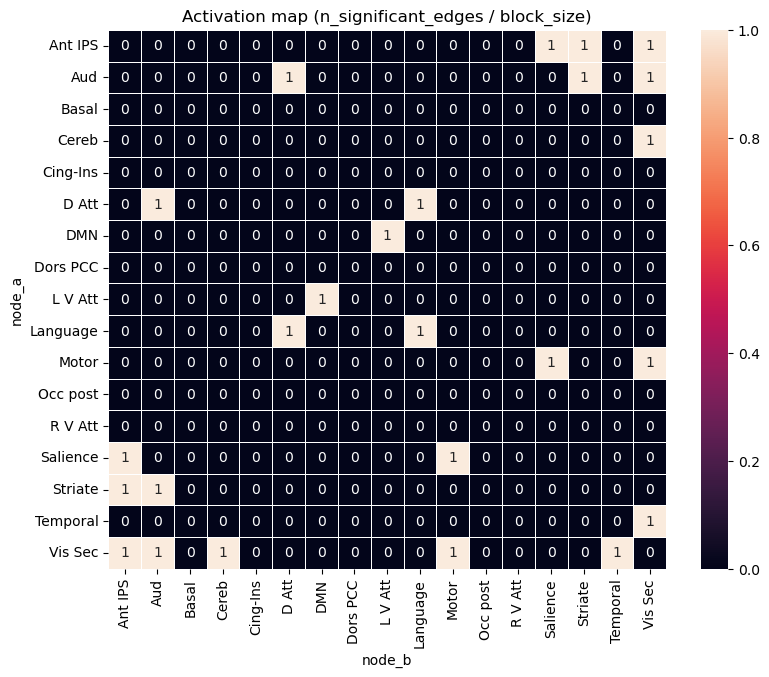

In [ ]:
heat_k2 = heat_kwargs.copy()
heat_k2.pop("vmax")
plt.subplots(1, 1, figsize=(9, 7))
sns.heatmap(comparisons_pv.loc[:, "activation"], **heat_k2)
plt.title("Activation map (n_significant_edges / block_size)")
plt.show()

In [ ]:
comparisons

,node_a,node_b,npos,nneg,activation
0,Ant IPS,Ant IPS,0,0,False
1,Ant IPS,Aud,0,0,False
2,Ant IPS,Basal,0,0,False
3,Ant IPS,Cereb,0,0,False
4,Ant IPS,Cing-Ins,0,0,False
...,...,...,...,...,...
284,Vis Sec,R V Att,0,0,False
285,Vis Sec,Salience,0,0,False
286,Vis Sec,Striate,0,0,False
287,Vis Sec,Temporal,0,1,True


In [ ]:
comparisons_pv.stack().reset_index()

,node_a,node_b,npos,nneg,activation
0,Ant IPS,Ant IPS,0,0,False
1,Ant IPS,Aud,0,0,False
2,Ant IPS,Basal,0,0,False
3,Ant IPS,Cereb,0,0,False
4,Ant IPS,Cing-Ins,0,0,False
...,...,...,...,...,...
284,Vis Sec,R V Att,0,0,False
285,Vis Sec,Salience,0,0,False
286,Vis Sec,Striate,0,0,False
287,Vis Sec,Temporal,0,1,True


In [ ]:
atlas.labels

['L Aud',
 'R Aud',
 'Striate',
 'L DMN',
 'Med DMN',
 'Front DMN',
 'R DMN',
 'Occ post',
 'Motor',
 'R DLPFC',
 'R Front pol',
 'R Par',
 'R Post Temp',
 'Basal',
 'L Par',
 'L DLPFC',
 'L Front pol',
 'L IPS',
 'R IPS',
 'L LOC',
 'Vis',
 'R LOC',
 'D ACC',
 'V ACC',
 'R A Ins',
 'L STS',
 'R STS',
 'L TPJ',
 'Broca',
 'Sup Front S',
 'R TPJ',
 'R Pars Op',
 'Cereb',
 'Dors PCC',
 'L Ins',
 'Cing',
 'R Ins',
 'L Ant IPS',
 'R Ant IPS']

In [ ]:
view = plotting.view_connectome(tstats, coords, edge_threshold="90%")
view.open_in_browser()